# Top Tagging
Now that we have finished with processing the data files, lets actually get to top tagging.

In [1]:
# Allows for plotting within the notebook
%matplotlib inline

# Packages from last time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The commands make the plots look nice
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'font.serif': 'cmr10',
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'figure.figsize': (3, 3),
                     'figure.dpi': 80,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True,
                     'axes.formatter.use_mathtext': True
                     })

In [3]:
import keras
from keras import Sequential    # This is the easiest method to build
                                # a network, but not the most flexible
    
from keras.layers import Dense, Dropout  # For layers which are fully connected
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Load Data - N subjettiness

In [4]:
training_n = np.load('../data/top_tagging/smaller_raw/nsubjettiness_training.npy')
val_n = np.load('../data/top_tagging/smaller_raw/nsubjettiness_val.npy')
test_n = np.load('../data/top_tagging/smaller_raw/nsubjettiness_test.npy')

In [5]:
training_labels = np.load('../data/top_tagging/smaller_raw/training_labels.npy')
val_labels = np.load('../data/top_tagging/smaller_raw/val_labels.npy')
test_labels = np.load('../data/top_tagging/smaller_raw/test_labels.npy')

Scale the data

In [6]:
SS_n = StandardScaler()
training_n = SS_n.fit_transform(training_n)
val_n = SS_n.transform(val_n)
test_n = SS_n.transform(test_n)

Build a network

In [7]:
n_sub_model = Sequential()
n_sub_model.add(Dense(100, input_dim=training_n.shape[1], activation='relu'))
n_sub_model.add(Dropout(rate=0.2))
n_sub_model.add(Dense(100, activation='relu'))
n_sub_model.add(Dropout(rate=0.2))
n_sub_model.add(Dense(100, activation='relu'))
n_sub_model.add(Dropout(rate=0.2))
n_sub_model.add(Dense(100, activation='relu'))
n_sub_model.add(Dense(1, activation='sigmoid'))

# Now we compile, where we tell Adam where to start at.
n_sub_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))

n_sub_model.summary()

2021-12-29 12:43:05.766388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-29 12:43:05.766519: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-29 12:43:05.766586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (13544a510077): /proc/driver/nvidia/version does not exist
2021-12-29 12:43:05.820744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

In [8]:
es = EarlyStopping(patience=8,                # If the validation loss has not improved for 15 epochs, stop training
                   restore_best_weights=True,  # When we stop, go back to when it generalized to the validation data the best
                   verbose=1)

reduce_rate = ReduceLROnPlateau(patience=3, # If the validation loss has not improved for 5 epochs, lower the rate
                                factor=0.1, # cut the rate in half
                                verbose=1,  # Tell us when this happens
                                min_lr=1e-5 # If the learning rate is too small, the updates don't do very much
                               )
my_callbacks = [es, reduce_rate]

In [9]:
training_history_n = n_sub_model.fit(training_n, training_labels,
                                     validation_data=(val_n, val_labels),
                                     epochs=200,
                                     callbacks=my_callbacks,
                                     verbose=1
                                    )

2021-12-29 12:43:10.298132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
6250/6250 [==============================] - 25s 4ms/step - loss: 0.2852 - val_loss: 0.2615
Epoch 2/200
6250/6250 [==============================] - 24s 4ms/step - loss: 0.2611 - val_loss: 0.2568
Epoch 3/200
6250/6250 [==============================] - 31s 5ms/step - loss: 0.2530 - val_loss: 0.2438
Epoch 4/200
6250/6250 [==============================] - 19s 3ms/step - loss: 0.2496 - val_loss: 0.2421
Epoch 5/200
6250/6250 [==============================] - 21s 3ms/step - loss: 0.2480 - val_loss: 0.2462
Epoch 6/200
6250/6250 [==============================] - 22s 4ms/step - loss: 0.2466 - val_loss: 0.2429
Epoch 7/200
6250/6250 [==============================] - 22s 3ms/step - loss: 0.2454 - val_loss: 0.2410
Epoch 8/200
6250/6250 [==============================] - 20s 3ms/step - loss: 0.2447 - val_loss: 0.2422
Epoch 9/200
6250/6250 [==============================] - 21s 3ms/step - loss: 0.2437 - val_loss: 0.2428
Epoch 10/200
6250/6250 [==============================] - 22s 4m

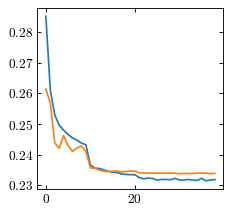

In [10]:
plt.plot(training_history_n.history['loss'])
plt.plot(training_history_n.history['val_loss'])

Now, let's get the predictions for the validation set and compute the area under the curve.

In [11]:
val_pred_n = n_sub_model.predict(val_n)

In [12]:
fpr_n, tpr_n, thresholds_n = roc_curve(y_true=val_labels,
                                       y_score=val_pred_n)

In [13]:
auc_n = auc(fpr_n, tpr_n)

background_eff_n = interp1d(tpr_n, fpr_n)
working_point_n = background_eff_n(0.3)

print(f'The area under the curve is {auc_n:0.3f}')
print(f'The backround rejection at signal efficieny 0.3 is {1/working_point_n:0.3f}')

The area under the curve is 0.965
The backround rejection at signal efficieny 0.3 is 312.500


## Images

To train convolutional networks, a GPU is VERY helpful. I assume that most people are not using a computer with a GPU. Therefore, let's try the technique of _transfer learning_. We will load in a model that is pretrained on a large batch of images (from google, facebook, etc). We will then chop off the last part of the network, and attach a few dense layers, and only allow the dense layers to train. Hopefully, the shape recognition coming from looking at millions of images will help us here.

In [14]:
training_images = np.load('../data/top_tagging/smaller_raw/training_images.npy')
val_images = np.load('../data/top_tagging/smaller_raw/val_images.npy')
test_images = np.load('../data/top_tagging/smaller_raw/test_images.npy')

In [15]:
training_images[0].shape

(33, 33, 1)

In [16]:
base_model = keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(33, 33, 3)
)
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(33, 33, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

ValueError: Input size must be at least 71x71; got `input_shape=(33, 33, 3)`

Unfortunately, it seems like our images are actually too small to use these methods for. Let's instead try training a basic CNN.

In [17]:
from keras.layers import Conv2D, MaxPool2D, Flatten

In [18]:
model_images = Sequential()
model_images.add(Conv2D(input_shape=(33, 33, 1), filters=10, kernel_size=3, activation='relu'))
model_images.add(Conv2D(filters=10, kernel_size=3, activation='relu'))
model_images.add(MaxPool2D(pool_size=(2, 2)))
model_images.add(Conv2D(input_shape=(33, 33, 1), filters=10, kernel_size=3, activation='relu'))
model_images.add(Conv2D(filters=10, kernel_size=3, activation='relu'))
model_images.add(MaxPool2D(pool_size=(2, 2)))
model_images.add(Flatten())
model_images.add(Dense(25, activation='relu'))
model_images.add(Dense(1, activation='sigmoid'))

In [19]:
model_images.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 10)        100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 10)        910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 10)        910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 250)              

In [20]:
model_images.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))

Similar to dense networks, it can also be useful to normalize the images. Load in the zero_center and standardize functions which will subtract the mean image and divide by the standard deviation per pixel.

In [21]:
from energyflow.utils import standardize, zero_center

In [22]:
training_images_norm, val_images_norm, test_images_norm = standardize(*zero_center(
    training_images, val_images, test_images))


In [23]:
training_history_images = model_images.fit(training_images_norm, training_labels,
                                           validation_data=(val_images_norm, val_labels),
                                           epochs=50,
                                           callbacks=my_callbacks,
                                           verbose=1
                                          )

Epoch 1/50
6250/6250 [==============================] - 179s 29ms/step - loss: 0.2610 - val_loss: 0.2449
Epoch 2/50
6250/6250 [==============================] - 188s 30ms/step - loss: 0.2344 - val_loss: 0.2376
Epoch 3/50
6250/6250 [==============================] - 217s 35ms/step - loss: 0.2285 - val_loss: 0.2244
Epoch 4/50
6250/6250 [==============================] - 196s 31ms/step - loss: 0.2238 - val_loss: 0.2258
Epoch 5/50
6250/6250 [==============================] - 189s 30ms/step - loss: 0.2212 - val_loss: 0.2277
Epoch 6/50
6250/6250 [==============================] - 181s 29ms/step - loss: 0.2181 - val_loss: 0.2245

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
6250/6250 [==============================] - 182s 29ms/step - loss: 0.2050 - val_loss: 0.2162
Epoch 8/50
6250/6250 [==============================] - 203s 32ms/step - loss: 0.2027 - val_loss: 0.2161
Epoch 9/50
6250/6250 [==============================] - 181s 29ms/step - loss:

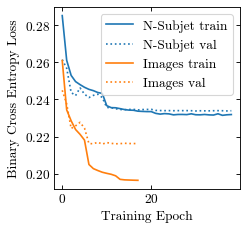

In [24]:
plt.plot(training_history_n.history['loss'], color='C0', label='N-Subjet train')
plt.plot(training_history_n.history['val_loss'], color='C0', ls=':', label='N-Subjet val')
plt.plot(training_history_images.history['loss'], color='C1', label='Images train')
plt.plot(training_history_images.history['val_loss'], color='C1', ls=':', label='Images val')
plt.legend(loc='upper right')
plt.xlabel('Training Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.show()

In [25]:
val_pred_im = model_images.predict(val_images_norm)

In [26]:
fpr_im, tpr_im, thresholds_im = roc_curve(y_true=val_labels,
                                          y_score=val_pred_im)

In [27]:
auc_im = auc(fpr_im, tpr_im)

background_eff_im = interp1d(tpr_im, fpr_im)
working_point_im = background_eff_im(0.3)

print(f'The area under the curve is {auc_im:0.3f}')
print(f'The backround rejection at signal efficieny 0.3 is {1/working_point_im:0.3f}')

The area under the curve is 0.970
The backround rejection at signal efficieny 0.3 is 333.333


## Comparisons

/tmp/ipykernel_68/4083190323.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_n, 1/fpr_n, label='N-Subjet')
/tmp/ipykernel_68/4083190323.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_im, 1/fpr_im, label='Images')


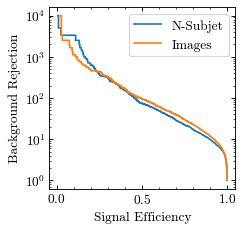

In [35]:
plt.plot(tpr_n, 1/fpr_n, label='N-Subjet')
plt.plot(tpr_im, 1/fpr_im, label='Images')
plt.minorticks_on()
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.show()

/tmp/ipykernel_68/1687139291.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_n, tpr_n/np.sqrt(fpr_n), label='N-Subjet')
/tmp/ipykernel_68/1687139291.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr_n, tpr_n/np.sqrt(fpr_n), label='N-Subjet')
/tmp/ipykernel_68/1687139291.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_im, tpr_im/np.sqrt(fpr_im), label='Images')
/tmp/ipykernel_68/1687139291.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(tpr_im, tpr_im/np.sqrt(fpr_im), label='Images')


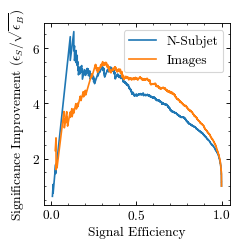

In [41]:
plt.plot(tpr_n, tpr_n/np.sqrt(fpr_n), label='N-Subjet')
plt.plot(tpr_im, tpr_im/np.sqrt(fpr_im), label='Images')
plt.minorticks_on()
# plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('Signal Efficiency')
plt.ylabel(r'Significance Improvement ($\epsilon_S / \sqrt{\epsilon_B}$)')
plt.show()

Questions:
 * Which basis/method is more efficient?
 * How do these results compare to the top-tagging challenge?
 * How could we improve the results?

# Anomaly Detection